In [43]:
import os
import shutil
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load Data , Create DataFrame 

In [44]:
IMG_PATH = r"D:\INSTANT(Course)\Training Month\Sprint2\Project Computer Vision\Brain_Tumor_Data\brain_tumor_dataset"

data = []

for label in ['yes', 'no']:
    folder = os.path.join(IMG_PATH, label)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(folder, filename)
            data.append({
                'filepath': full_path,
                'label': label.upper()  
            })

df = pd.DataFrame(data)
print(df.head())


                                            filepath label
0  D:\INSTANT(Course)\Training Month\Sprint2\Proj...   YES
1  D:\INSTANT(Course)\Training Month\Sprint2\Proj...   YES
2  D:\INSTANT(Course)\Training Month\Sprint2\Proj...   YES
3  D:\INSTANT(Course)\Training Month\Sprint2\Proj...   YES
4  D:\INSTANT(Course)\Training Month\Sprint2\Proj...   YES


In [45]:
df.head()

,filepath,label
0,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,YES
1,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,YES
2,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,YES
3,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,YES
4,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,YES


In [46]:
print(df['label'].value_counts())

label
YES    155
NO      98
Name: count, dtype: int64


# Splitting Data

In [47]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 202, Val: 25, Test: 26


In [48]:
print("Train distribution:\n", train_df['label'].value_counts(normalize=True))
print("Val distribution:\n", val_df['label'].value_counts(normalize=True))
print("Test distribution:\n", test_df['label'].value_counts(normalize=True))


Train distribution:
 label
YES    0.613861
NO     0.386139
Name: proportion, dtype: float64
Val distribution:
 label
YES    0.6
NO     0.4
Name: proportion, dtype: float64
Test distribution:
 label
YES    0.615385
NO     0.384615
Name: proportion, dtype: float64


# Generate Data

In [49]:
height = 224
width = 224
batch_size= 32

In [50]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_generator = ImageDataGenerator(rescale=1./255)


In [51]:
train_data_gen = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",        
    y_col="label", 
    batch_size=batch_size,
    shuffle=True,
    class_mode="binary",
    color_mode="rgb",
    target_size=(height, width)
)

validation_data_gen = val_test_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",        
    y_col="label", 
    batch_size=batch_size,
    shuffle=True,
    class_mode="binary",
    color_mode="rgb",
    target_size=(height, width)
)

test_data_gen = val_test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",        
    y_col="label", 
    batch_size=batch_size,
    shuffle=False,
    class_mode="binary",
    color_mode="rgb",
    target_size=(height, width)
)


Found 202 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


In [52]:
train_data_gen.class_indices


{'NO': 0, 'YES': 1}

# Visualize Image 

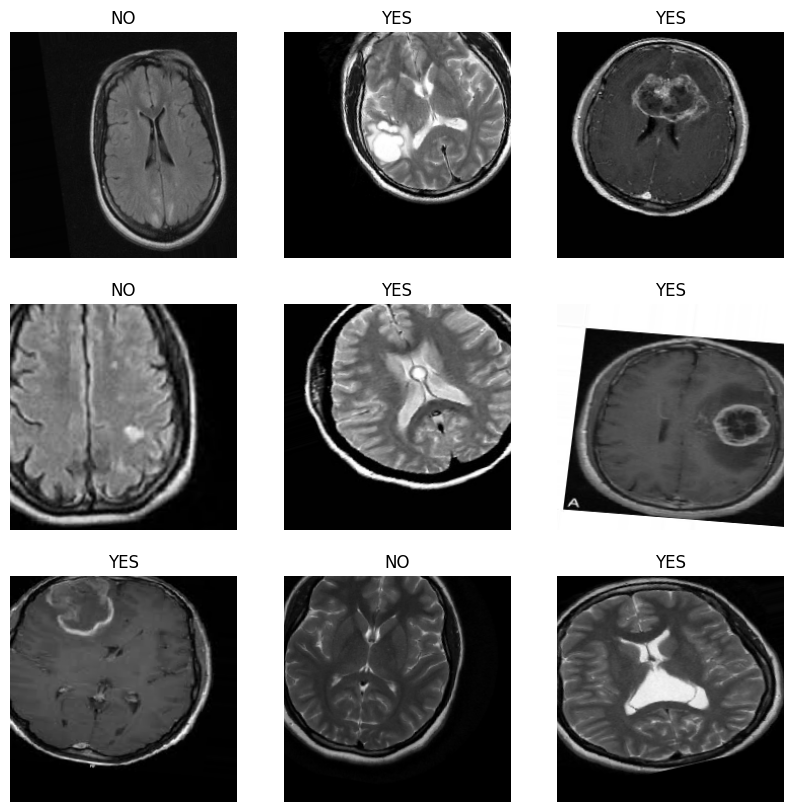

In [53]:
images, labels = next(train_data_gen)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title("YES" if labels[i]==1 else "NO")
    plt.axis("off")
plt.show()


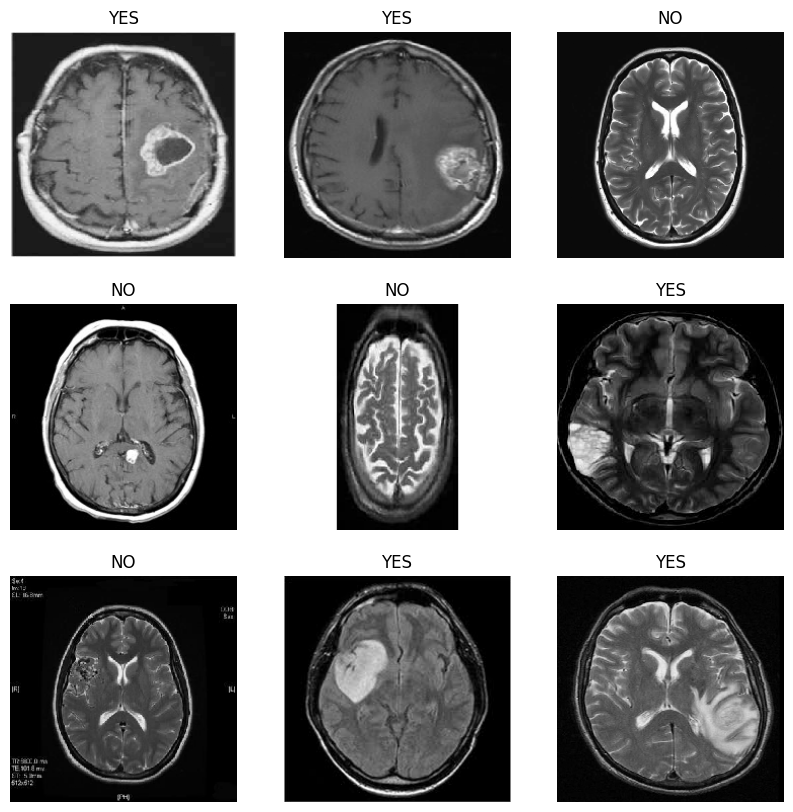

In [54]:
images, labels = next(test_data_gen)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title("YES" if labels[i]==1 else "NO")
    plt.axis("off")
plt.show()


# Load ResNet50V2 & Training Model 

In [55]:
tf.keras.backend.clear_session()

base_model = ResNet50V2( input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 524,801
Non-trainable params: 23,564,800
______________________________________

In [56]:
model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])


In [ ]:
checkpoint = ModelCheckpoint('model/resnet50v2_best.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
early = EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)

In [58]:
history = model.fit(train_data_gen, validation_data=validation_data_gen, epochs=30,callbacks=[early,checkpoint])

Epoch 1/30
6/7 [========================>.....] - ETA: 0s - loss: 0.6105 - accuracy: 0.6875
Epoch 1: accuracy improved from -inf to 0.69307, saving model to model\resnet50v2_best.h5
7/7 [==============================] - 8s 763ms/step - loss: 0.6033 - accuracy: 0.6931 - val_loss: 0.2021 - val_accuracy: 0.9600
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8317
Epoch 2: accuracy improved from 0.69307 to 0.83168, saving model to model\resnet50v2_best.h5
7/7 [==============================] - 3s 465ms/step - loss: 0.3937 - accuracy: 0.8317 - val_loss: 0.2718 - val_accuracy: 0.8800
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8416
Epoch 3: accuracy improved from 0.83168 to 0.84158, saving model to model\resnet50v2_best.h5
7/7 [==============================] - 3s 485ms/step - loss: 0.4499 - accuracy: 0.8416 - val_loss: 0.3645 - val_accuracy: 0.7600
Epoch 4/30
6/7 [========================>.....] - ETA: 0s - l

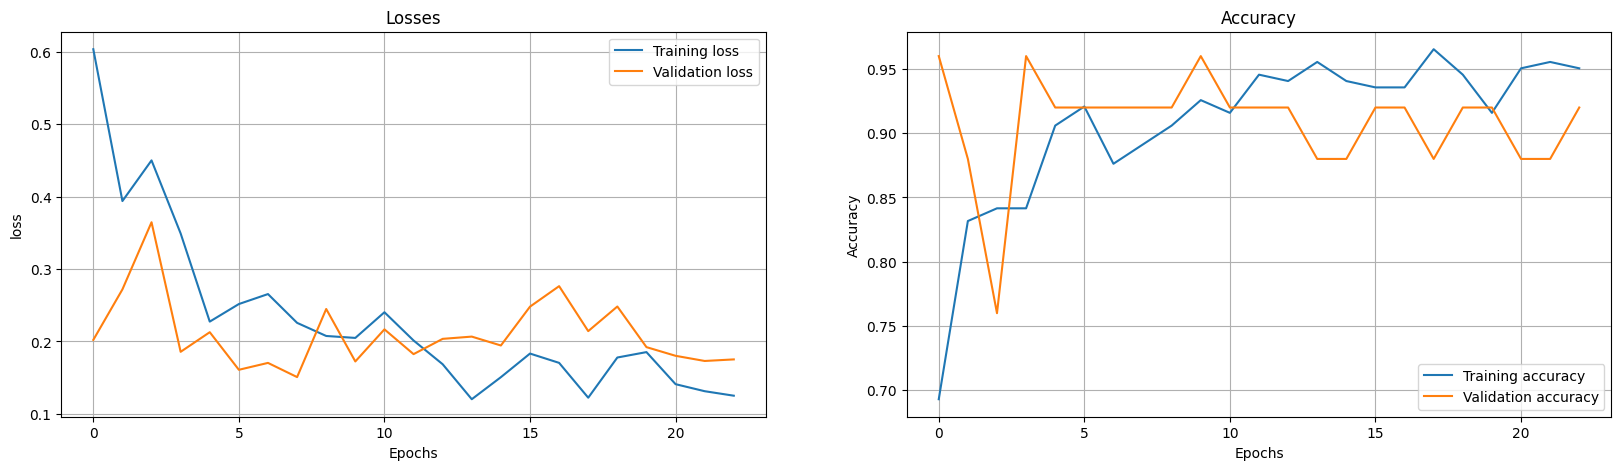

In [66]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# Save & Load Model

In [60]:
model.save('model-brain-mri-ResNet50V2.h5')


# Evaluate & Confusion Matrix , Classification Report

In [61]:
train_result = model.evaluate(train_data_gen)
val_result = model.evaluate(validation_data_gen)

test_result = model.evaluate(test_data_gen)

1/1 [==============================] - 0s 133ms/step - loss: 0.3135 - accuracy: 0.9231


In [62]:
model_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model_result

,Train,Validation,Testing
Loss,0.133574,0.214183,0.313451
Accuracy,0.950495,0.880000,0.923077


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_prob = model.predict(test_data_gen)

y_pred = (y_pred_prob > 0.5).astype(int).flatten()

y_true = test_data_gen.classes  

print("Accuracy Score:", accuracy_score(y_true, y_pred))


1/1 [==============================] - 1s 693ms/step
Accuracy Score: 0.9230769230769231


<Axes: >

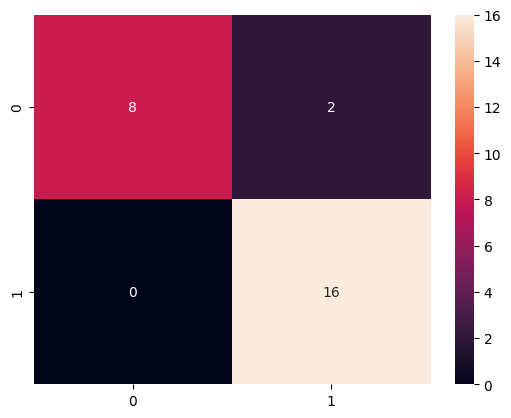

In [64]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

In [65]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["NO", "YES"]))


Classification Report:
               precision    recall  f1-score   support

          NO       1.00      0.80      0.89        10
         YES       0.89      1.00      0.94        16

    accuracy                           0.92        26
   macro avg       0.94      0.90      0.92        26
weighted avg       0.93      0.92      0.92        26

